In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [4]:
import pulse_compiler_helper_fns

In [5]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = q.IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_armonk')
defaults = backend.defaults()
circ_inst_map = defaults.circuit_instruction_map
measure = circ_inst_map.get('measure', qubits=backend.configuration().meas_map[0])

## RB Schedules

In [7]:
from qiskit.transpiler.passes.optimize_1q_gates import Optimize1qGates

schedules_std = []
schedules_opt = []


for k in range(1, 25):
    circuit = q.QuantumCircuit(1)

    total_theta, total_phi, total_lam = 0, 0, 0

    for i in range(k):
        theta, phi, lam = np.random.rand() * np.pi, np.random.rand() * np.pi, np.random.rand() * np.pi
        circuit.u3(theta, phi, lam, 0)
        total_theta, total_phi, total_lam = Optimize1qGates.compose_u3(
            theta, phi, lam, total_theta, total_phi, total_lam)

    circuit.u3(-total_theta, -total_lam, -total_phi, 0)  # inverse of U3(theta, phi, lam) is U3(-theta, -lam, -phi)


    transpiled_circuit = q.transpile(circuit, backend, optimization_level=0)
    schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
    schedule |= measure << schedule.duration
    schedules_std.append(schedule)

    with qiskit.PulseBackedOptimizationContext():
        decomposed_circuit = circuit.decompose()
        pulse_compiler_helper_fns.update_basis_gates_and_circ_inst_map(decomposed_circuit, backend, circ_inst_map)
        transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=0)
        schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
        schedule |= measure << schedule.duration
        schedules_opt.append(schedule)

### Set up State Tomography

In [8]:
job_std = q.execute(schedules_std, backend=backend, shots=8000)
job_opt = q.execute(schedules_opt, backend=backend, shots=8000)
print('job_std is %s' % job_std.job_id())
print('job_opt is %s' % job_opt.job_id())

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '


job_std is 5e3793188f07c60018f68168
job_opt is 5e3793238f07c60018f68169


In [9]:
std_result = job_std.result()
opt_result = job_opt.result()

In [12]:
std_probs, opt_probs = [], []
for i in range(24):
    std_probs.append(std_result.get_counts(i).get('0', 0) / 8000)
    opt_probs.append(opt_result.get_counts(i).get('0', 0) / 8000)

In [13]:
np.mean(std_probs), np.mean(opt_probs)

(0.9432083333333333, 0.9492083333333333)

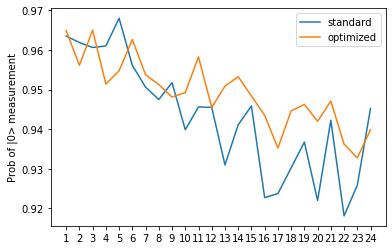

In [15]:
plt.plot(range(1, 25), std_probs)
plt.plot(range(1, 25), opt_probs)
plt.xticks(range(1, 25));
plt.legend(['standard', 'optimized'])
plt.ylabel('Prob of |0> measurement');